In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import os
import sys
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.pre_proc.utils import (convert_strings_to_categories,
                                get_time_related_columns,
                                replace_categorical_features_to_numerical_codes,
                                replace_numerical_missing_values_with_medians)

from src.models.utils import get_readable_model_scores

In [4]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)


### Reading pre_proc data

In [ ]:
pre_proc_df = pd.read_parquet('../data/pre_proc_data.parquet', engine='pyarrow')
# Somehow I need to do object convertion to category again, after read_parquet.
pre_proc_df = convert_strings_to_categories(pre_proc_df)
# Concentrate on sold items.
pre
pre_proc_df = pre_proc_df[pre_proc_df.]

In [6]:
target = 'listing_price_local'

### Descriptive statistics of the target

In [7]:
pre_proc_df[target].describe()

count    122194.000000
mean         12.948721
std          30.151083
min           0.000000
25%           5.000000
50%           8.000000
75%          14.000000
max        1000.000000
Name: listing_price_local, dtype: float64

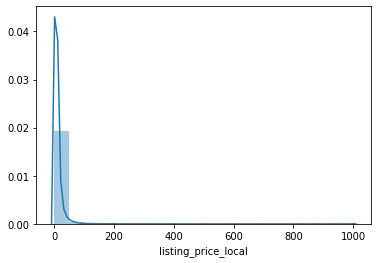

In [8]:
sns.distplot(pre_proc_df[target], bins = 20);

In [9]:
hist, bin_edges = np.histogram(pre_proc_df[target], bins = 20)
hist / hist.sum(), bin_edges

(array([9.70170385e-01, 2.03774326e-02, 4.23097697e-03, 1.90680393e-03,
        9.41126406e-04, 4.41920225e-04, 4.17369102e-04, 3.27348315e-04,
        2.29143820e-04, 1.06388202e-04, 1.39123034e-04, 1.06388202e-04,
        9.82044945e-05, 2.45511236e-05, 8.18370787e-05, 4.09185394e-05,
        3.27348315e-05, 6.54696630e-05, 3.27348315e-05, 2.29143820e-04]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000.]))

Target `listing_price_local` is from interval `[0:1000]`, but 97% of selling prices are from `[0:50]` interval and 99% of selling prices are from `[0:100]`. This variable is shewed to the right with high peak. Due to I will remove outliers.

In [10]:
pre_proc_df = pre_proc_df[pre_proc_df.listing_price_local < 150]

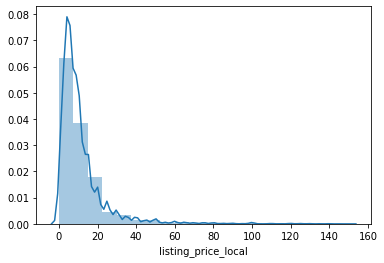

In [11]:
sns.distplot(pre_proc_df[target], bins = 20);

### Relationship with categorical variables

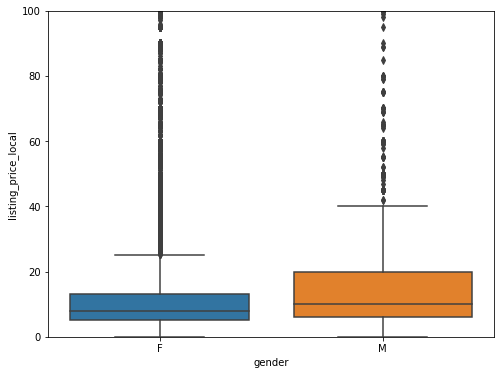

In [12]:
var = 'gender'
data = pd.concat([pre_proc_df[target], pre_proc_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=100);

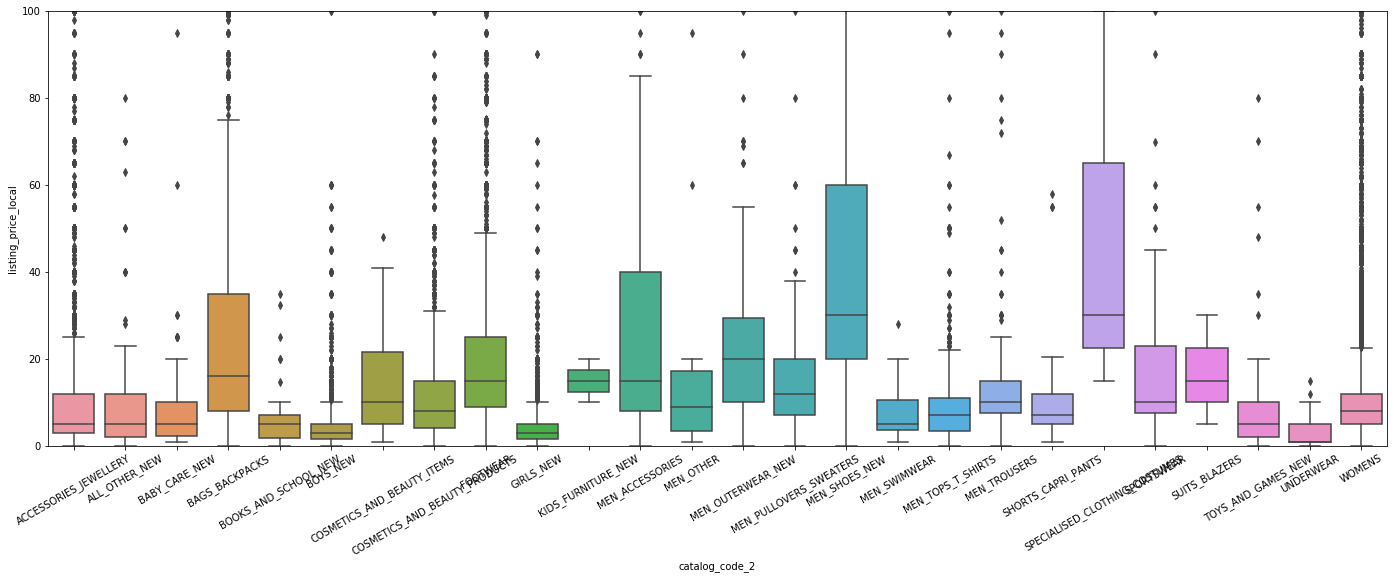

In [13]:
var = 'catalog_code_2'
data = pd.concat([pre_proc_df[target], pre_proc_df[var]], axis=1)
f, ax = plt.subplots(figsize=(24, 8))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=100);

Both man and woman used to sell their items on the same price.`SPECIALISED_CLOTHING_CUSTUMES` and `MEN_SHOES_NEW` tends to be more expensive than average.

### Remove sale_time related columns, because it is unknow during listing_price_local prediction

In [14]:
sale_time_columns = get_time_related_columns(pre_proc_df.columns, 'sale_time')

In [15]:
sale_time_columns

['sale_timeDay',
 'sale_timeHour',
 'sale_timeDayofyear',
 'sale_timeMonth',
 'sale_timeWeek',
 'sale_timeDayofweek']

In [16]:
train_columns = list(set(pre_proc_df.columns) - set(sale_time_columns))
pre_proc_df = pre_proc_df[train_columns]

### Method1

* replace_categorical_features_to_numerical_codes
* replace_numerical_missing_values_with_medians

In [17]:
df = replace_categorical_features_to_numerical_codes(pre_proc_df)
df = replace_numerical_missing_values_with_medians(df)

In [18]:
test_size = 0.05
df_subset = df.sample(frac=0.5)
train_columns = list(set(df_subset.columns) - set([target]))


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_subset[train_columns],
                                                    df_subset[target],
                                                    test_size=test_size)
print(X_train.shape, X_test.shape)

(57739, 96) (3039, 96)


### Base model

In [20]:
%%time
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(get_readable_model_scores(m.predict(X_train), y_train))
print(get_readable_model_scores(m.predict(X_test), y_test))


RMSE: 4.42406682270046,
absolute mean: 2.325674968392248,
overpriced predictions mean: 2.27668747217806, 
overpriced predictions count: 31450, 
underpriced predictions mean: -2.7367736104440463, 
underpriced predictions count: 22903, 

RMSE: 10.883231638670303,
absolute mean: 5.986470549522869,
overpriced predictions mean: 5.090441475146981, 
overpriced predictions count: 1871, 
underpriced predictions mean: -7.671387610619469, 
underpriced predictions count: 1130, 

CPU times: user 40.2 s, sys: 214 ms, total: 40.4 s
Wall time: 4.9 s


In [21]:
feature_importance = rf_feat_importance(m, X_train)
feature_importance

cols       imp
63                            package_size_code  0.104325
80                                        brand  0.078203
14                              window_gmv_sold  0.042253
60                          window_items_listed  0.038601
7                                catalog_code_4  0.038195
40                               catalog_code_3  0.031142
29                               catalog_code_2  0.028019
77                               total_gmv_sold  0.021862
50                            window_items_sold  0.019353
84                                         city  0.018674
67                                         size  0.016586
11                    lister_nth_day_of_listing  0.016367
70                           total_items_listed  0.015298
73                               catalog_code_1  0.014539
39                          local_timeDayofyear  0.013640
48                     first_sale_local_timeDay  0.013307
19                                     birthday  0.013140
58                                color_primary  0.013121
37                               local_timeHour  0.012379
17            basic_verification_local_timeHour  0.012142
47                                local_timeDay  0.012012
81                           lister_nth_listing  0.011544
21                    first_sale_local_timeHour  0.011518
93                 first_listing_local_timeHour  0.011274
64                      days_since_registration  0.011248
27                    second_sale_local_timeDay  0.011028
46                   second_sale_local_timeHour  0.010917
25                                          age  0.010678
86                  registration_local_timeHour  0.010549
24                                        state  0.010510
34                         total_feedback_count  0.010499
68             basic_verification_local_timeDay  0.010052
20          first_faq_entry_view_local_timeHour  0.009987
75       first_upload_form_visit_local_timeHour  0.009976
44              first_wanted_item_local_timeDay  0.009831
71                days_since_user_first_listing  0.009512
90             first_wanted_item_local_timeHour  0.009315
66           first_faq_entry_view_local_timeDay  0.009162
26                             total_items_sold  0.008980
32     first_faq_entry_view_local_timeDayofyear  0.008757
61              second_sale_local_timeDayofyear  0.008673
36                             total_gmv_bought  0.008191
51                   registration_local_timeDay  0.008005
4                   first_listing_local_timeDay  0.007997
3                           local_timeDayofweek  0.007817
92                total_positive_feedback_count  0.007428
57       basic_verification_local_timeDayofyear  0.007398
76             registration_local_timeDayofyear  0.007316
59                   second_sale_local_timeWeek  0.007283
41        first_upload_form_visit_local_timeDay  0.007185
30        first_wanted_item_local_timeDayofyear  0.007106
45                               local_timeWeek  0.006832
42               first_sale_local_timeDayofyear  0.006806
18        first_wanted_item_local_timeDayofweek  0.006088
55                            window_gmv_bought  0.005908
56                           total_items_bought  0.005696
9           first_faq_entry_view_local_timeWeek  0.005607
13  first_upload_form_visit_local_timeDayofweek  0.005266
15     first_faq_entry_view_local_timeDayofweek  0.005081
8                first_sale_local_timeDayofweek  0.005074
79       basic_verification_local_timeDayofweek  0.005043
54  first_upload_form_visit_local_timeDayofyear  0.005009
5               second_sale_local_timeDayofweek  0.004853
22             first_wanted_item_local_timeWeek  0.004839
6                              listing_activity  0.004172
33            first_listing_local_timeDayofyear  0.004157
88             registration_local_timeDayofweek  0.004146
94            first_listing_local_timeDayofweek  0.004146
69                        registration_fu

In [22]:
selected_columns_reduced = feature_importance[feature_importance.imp > 0.01].cols.tolist()

X_train, X_test, y_train, y_test = train_test_split(df_subset[selected_columns_reduced],
                                                    df_subset[target],
                                                    test_size=test_size)

In [23]:
%%time
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(get_readable_model_scores(m.predict(X_train), y_train))
print(get_readable_model_scores(m.predict(X_test), y_test))

RMSE: 4.4142197371965715,
absolute mean: 2.3244445175704462,
overpriced predictions mean: 2.2517654069859834, 
overpriced predictions count: 31463, 
underpriced predictions mean: -2.747541713641488, 
underpriced predictions count: 23062, 

RMSE: 9.902269493509031,
absolute mean: 5.700504113195131,
overpriced predictions mean: 5.118659485023647, 
overpriced predictions count: 1903, 
underpriced predictions mean: -6.912509571558797, 
underpriced predictions count: 1097, 

CPU times: user 13.4 s, sys: 89.4 ms, total: 13.5 s
Wall time: 1.7 s


### Method 2

* replace high cardinality categorical features to numerical codes
* replace low cardinality categorical features with one-hot-encoding
* replace_numerical_missing_values_with_median

In [24]:
for column, c in pre_proc_df.items():
    if is_categorical_dtype(c):
        print(column)
        print(len(c.cat.categories))

gender
2
listing_activity
4
catalog_code_4
347
registration_type
5
paid_organic
2
birthday
7757
state
66
listing_platform
3
catalog_code_2
26
registration_platform
4
catalog_code_3
205
got_voucher
2
disposal_conditions_string
2
color_primary
28
acquisition_type
4
package_size_code
4
size
192
registration_full_utm
604
catalog_code_1
4
brand
5934
city
5109


In [25]:
df = pd.get_dummies(pre_proc_df, columns=['registration_type',
                                          'gender',
                                          'state',
                                          'paid_organic',
                                          'catalog_code_1',
                                          'color_primary',
                                          'package_size_code'], dummy_na=True)

df = replace_categorical_features_to_numerical_codes(df)
df = replace_numerical_missing_values_with_medians(df)

In [26]:
test_size = 0.05
df_subset = df.sample(frac=0.5)
train_columns = list(set(df_subset.columns) - set([target]))


In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_subset[train_columns],
                                                    df_subset[target],
                                                    test_size=test_size)
print(X_train.shape, X_test.shape)

(57739, 207) (3039, 207)


In [28]:
%%time
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(get_readable_model_scores(m.predict(X_train), y_train))
print(get_readable_model_scores(m.predict(X_test), y_test))

RMSE: 4.329456444429292,
absolute mean: 2.2668975562444795,
overpriced predictions mean: 2.1933410683293695, 
overpriced predictions count: 31114, 
underpriced predictions mean: -2.7063889056897223, 
underpriced predictions count: 23147, 

RMSE: 9.823387026157501,
absolute mean: 5.391003290556103,
overpriced predictions mean: 4.767619672131148, 
overpriced predictions count: 1830, 
underpriced predictions mean: -6.51234268707483, 
underpriced predictions count: 1176, 

CPU times: user 56.6 s, sys: 383 ms, total: 57 s
Wall time: 7.16 s


In [29]:
feature_importance = rf_feat_importance(m, X_train)
feature_importance

cols           imp
203                      package_size_code_SMALL  9.456566e-02
81                                         brand  7.166374e-02
57                           window_items_listed  4.116137e-02
13                               window_gmv_sold  3.866047e-02
9                                 catalog_code_4  3.324535e-02
132                               catalog_code_2  2.952174e-02
142                               catalog_code_3  2.700029e-02
79                                total_gmv_sold  2.307019e-02
154                            window_items_sold  1.669225e-02
86                                          city  1.668815e-02
129                             total_items_sold  1.496757e-02
20                                      birthday  1.470736e-02
64                                          size  1.433294e-02
117                    lister_nth_day_of_listing  1.406792e-02
170                           total_items_listed  1.397099e-02
101                  catalog_code_1_CHILDREN_NEW  1.292043e-02
46                    second_sale_local_timeHour  1.262196e-02
151                                local_timeDay  1.253386e-02
37                                local_timeHour  1.224832e-02
18             basic_verification_local_timeHour  1.158202e-02
141                          local_timeDayofyear  1.155025e-02
137                         total_feedback_count  1.080416e-02
165                      days_since_registration  1.054765e-02
95                      package_size_code_MEDIUM  1.016442e-02
65              basic_verification_local_timeDay  1.016185e-02
126                                          age  9.873035e-03
167           first_faq_entry_view_local_timeDay  9.807388e-03
44               first_wanted_item_local_timeDay  9.806705e-03
21           first_faq_entry_view_local_timeHour  9.787664e-03
84                            lister_nth_listing  9.448091e-03
25                     second_sale_local_timeDay  9.196470e-03
103                 first_listing_local_timeHour  9.077217e-03
133        first_wanted_item_local_timeDayofyear  9.021900e-03
176       first_upload_form_visit_local_timeHour  8.935469e-03
49                      first_sale_local_timeDay  8.586620e-03
135     first_faq_entry_view_local_timeDayofyear  8.469476e-03
59               second_sale_local_timeDayofyear  8.464451e-03
88                   registration_local_timeHour  8.390238e-03
172                days_since_user_first_listing  8.325885e-03
22                     first_sale_local_timeHour  8.100262e-03
34                              total_gmv_bought  7.787831e-03
146               first_sale_local_timeDayofyear  7.640767e-03
195             first_wanted_item_local_timeHour  7.379630e-03
54                             window_gmv_bought  7.233933e-03
8                    first_listing_local_timeDay  6.981432e-03
56        basic_verification_local_timeDayofyear  6.681525e-03
199                total_positive_feedback_count  6.491353e-03
148                               local_timeWeek  6.133896e-03
110                          local_timeDayofweek  6.114069e-03
116          first_faq_entry_view_local_timeWeek  6.006587e-03
157                           total_items_bought  5.838083e-03
50                    registration_local_timeDay  5.735103e-03
19         first_wanted_item_local_timeDayofweek  5.689221e-03
41         first_upload_form_visit_local_timeDay  5.564064e-03
30             first_listing_local_timeDayofyear  5.313450e-03
183       basic_verification_local_timeDayofweek  5.099297e-03
115               first_sale_local_timeDayofweek  4.985108e-03
17      first_faq_entry_view_local_timeDayofweek  4.861723e-03
169                        registration_full_utm  4.838867e-03
53   first_upload_form_visit_local_timeDayofyear  4.830300e-03
161                   second_sale_local_timeWeek  4.725195e-03
23              first_wanted_item_local_timeWeek  4.688538e-03
178             registration_local_timeDayofyear  4.662646e-03
85          

In [30]:
selected_columns_reduced = feature_importance[feature_importance.imp > 0.01].cols.tolist()

X_train, X_test, y_train, y_test = train_test_split(df_subset[selected_columns_reduced],
                                                    df_subset[target],
                                                    test_size=test_size)

In [31]:
%%time
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(get_readable_model_scores(m.predict(X_train), y_train))
print(get_readable_model_scores(m.predict(X_test), y_test))

RMSE: 4.426665423626716,
absolute mean: 2.31433062954065,
overpriced predictions mean: 2.229802320441989, 
overpriced predictions count: 31675, 
underpriced predictions mean: -2.7640464952197092, 
underpriced predictions count: 22792, 

RMSE: 10.06532550663271,
absolute mean: 5.6924163193301895,
overpriced predictions mean: 5.020796803303763, 
overpriced predictions count: 1868, 
underpriced predictions mean: -6.990648513568416, 
underpriced predictions count: 1133, 

CPU times: user 10.4 s, sys: 76.9 ms, total: 10.5 s
Wall time: 1.38 s


### Method 3

* add categorical features frequency counts
* replace_categorical_features_to_numerical_codes
* replace_numerical_missing_values_with_median

In [32]:
df = pre_proc_df.copy()
for column, c in df.items():
    if is_categorical_dtype(c):
        freq = df[[column]].groupby(column).size().reset_index(name=column + '_freq')
        df = df.merge(freq, on=[column], how='left')


df = replace_categorical_features_to_numerical_codes(df)
df = replace_numerical_missing_values_with_medians(df)

In [33]:
test_size = 0.05
df_subset = df.sample(frac=0.5)
train_columns = list(set(df_subset.columns) - set([target]))


In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_subset[train_columns],
                                                    df_subset[target],
                                                    test_size=test_size)
print(X_train.shape, X_test.shape)

(57739, 117) (3039, 117)


In [35]:
%%time
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(get_readable_model_scores(m.predict(X_train), y_train))
print(get_readable_model_scores(m.predict(X_test), y_test))

RMSE: 4.524829111887209,
absolute mean: 2.3177584474964927,
overpriced predictions mean: 2.2520108438672257, 
overpriced predictions count: 31723, 
underpriced predictions mean: -2.755864955603658, 
underpriced predictions count: 22637, 

RMSE: 10.381432128318323,
absolute mean: 5.844237907206319,
overpriced predictions mean: 5.252317967522264, 
overpriced predictions count: 1909, 
underpriced predictions mean: -7.088876260311641, 
underpriced predictions count: 1091, 

CPU times: user 46.5 s, sys: 317 ms, total: 46.8 s
Wall time: 5.8 s


In [36]:
feature_importance = rf_feat_importance(m, X_train)
feature_importance

cols       imp
76                             package_size_code  0.077163
16                               window_gmv_sold  0.051838
93                                    brand_freq  0.048228
72                           window_items_listed  0.035655
98                                         brand  0.035065
51                           catalog_code_3_freq  0.028467
63                        package_size_code_freq  0.027542
42                                 birthday_freq  0.027165
9                                 catalog_code_4  0.021468
60                             window_items_sold  0.019957
95                                total_gmv_sold  0.019278
80                                          size  0.019085
32                                catalog_code_2  0.018654
85                            total_items_listed  0.015116
5                                      city_freq  0.014767
45                                catalog_code_3  0.014385
89                                catalog_code_1  0.013146
41                                local_timeHour  0.012623
103                                         city  0.012521
21                                      birthday  0.012090
44                           local_timeDayofyear  0.011616
57                                 local_timeDay  0.011280
13                     lister_nth_day_of_listing  0.011256
87                 days_since_user_first_listing  0.011199
36                           catalog_code_4_freq  0.010845
55                           catalog_code_2_freq  0.010561
58                      first_sale_local_timeDay  0.010469
38                          total_feedback_count  0.010199
67                                    state_freq  0.009986
100                           lister_nth_listing  0.009836
74               second_sale_local_timeDayofyear  0.009655
77                       days_since_registration  0.009551
56                            color_primary_freq  0.009327
54                    second_sale_local_timeHour  0.009304
110             first_wanted_item_local_timeHour  0.009036
79            first_faq_entry_view_local_timeDay  0.008889
113                                    size_freq  0.008777
33         first_wanted_item_local_timeDayofyear  0.008671
23                     first_sale_local_timeHour  0.008551
29                              total_items_sold  0.008456
105                  registration_local_timeHour  0.008411
26                                         state  0.008118
81              basic_verification_local_timeDay  0.008068
19             basic_verification_local_timeHour  0.007929
22           first_faq_entry_view_local_timeHour  0.007678
52               first_wanted_item_local_timeDay  0.007507
91        first_upload_form_visit_local_timeHour  0.007470
30                     second_sale_local_timeDay  0.007446
40                              total_gmv_bought  0.007202
114                 first_listing_local_timeHour  0.007115
70                                 color_primary  0.006980
66                             window_gmv_bought  0.006862
27                                           age  0.006571
35      first_faq_entry_view_local_timeDayofyear  0.006547
49                first_sale_local_timeDayofyear  0.006503
61                    registration_local_timeDay  0.006351
53                                local_timeWeek  0.005972
3                            local_timeDayofweek  0.005881
69        basic_verification_local_timeDayofyear  0.005846
47         first_upload_form_visit_local_timeDay  0.005503
6                    first_listing_local_timeDay  0.005462
112                total_positive_feedback_count  0.005384
10                first_sale_local_timeDayofweek  0.005207
17      first_faq_entry_view_local_timeDayofweek  0.005183
11           first_faq_entry_view_local_timeWeek  0.004766
65   first_upload_form_visit_local_timeDayofyear  0.004434
68                            total_items_bought  0.004393
37             first_listing_loc

In [37]:
selected_columns_reduced = feature_importance[feature_importance.imp > 0.01].cols.tolist()
print(len(selected_columns_reduced))
X_train, X_test, y_train, y_test = train_test_split(df_subset[selected_columns_reduced],
                                                    df_subset[target],
                                                    test_size=test_size)

28


In [38]:
%%time
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(get_readable_model_scores(m.predict(X_train), y_train))
print(get_readable_model_scores(m.predict(X_test), y_test))

RMSE: 4.412053917169672,
absolute mean: 2.308612838644178,
overpriced predictions mean: 2.2417584041604215, 
overpriced predictions count: 31549, 
underpriced predictions mean: -2.7231160587352705, 
underpriced predictions count: 22978, 

RMSE: 10.955379144019593,
absolute mean: 5.91695802974036,
overpriced predictions mean: 5.147296746413921, 
overpriced predictions count: 1869, 
underpriced predictions mean: -7.3538591322192906, 
underpriced predictions count: 1137, 

CPU times: user 10.7 s, sys: 79 ms, total: 10.8 s
Wall time: 1.4 s


### Insights after testing several basic random forests

* Bias and variance is quite huge.
* Different classical and easy categorical variables transformation methods are not signficantly different.

I tested several ideas classical ideas which helps to improve model performace. However significant accuracy difference between these methods doesn't turn up. I will continue with the first pre_poc approach.

### Hyperparameters

Lets do RandomizedSearchCV on smaller subset.

In [39]:
df = replace_categorical_features_to_numerical_codes(pre_proc_df)
df = replace_numerical_missing_values_with_medians(df)

In [40]:
test_size = 0.1
df_subset = df.sample(frac=0.1)
train_columns = list(set(df_subset.columns) - set([target]))
X_train, X_test, y_train, y_test = train_test_split(df_subset[train_columns],
                                                    df_subset[target],
                                                    test_size=test_size)
print(X_train.shape, X_test.shape)

(10940, 96) (1216, 96)


In [41]:
%%time
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(get_readable_model_scores(m.predict(X_train), y_train))
print(get_readable_model_scores(m.predict(X_test), y_test))

RMSE: 4.9015445582665835,
absolute mean: 2.66084478976234,
overpriced predictions mean: 2.521311255060729, 
overpriced predictions count: 6175, 
underpriced predictions mean: -3.1113384650735294, 
underpriced predictions count: 4352, 

RMSE: 11.01374844109326,
absolute mean: 6.619361842105263,
overpriced predictions mean: 5.7982602564102566, 
overpriced predictions count: 780, 
underpriced predictions mean: -8.16319675925926, 
underpriced predictions count: 432, 

CPU times: user 5.79 s, sys: 46.5 ms, total: 5.83 s
Wall time: 1.07 s


In [42]:
feature_importance = rf_feat_importance(m, X_train)
feature_importance

cols       imp
63                            package_size_code  0.109731
60                          window_items_listed  0.044743
80                                        brand  0.042900
67                                         size  0.040719
14                              window_gmv_sold  0.034380
29                               catalog_code_2  0.029149
7                                catalog_code_4  0.025816
20          first_faq_entry_view_local_timeHour  0.023929
40                               catalog_code_3  0.022333
71                days_since_user_first_listing  0.019615
21                    first_sale_local_timeHour  0.018200
55                            window_gmv_bought  0.018198
84                                         city  0.017119
50                            window_items_sold  0.015883
37                               local_timeHour  0.015539
39                          local_timeDayofyear  0.015445
11                    lister_nth_day_of_listing  0.015341
46                   second_sale_local_timeHour  0.015218
25                                          age  0.015052
73                               catalog_code_1  0.015027
19                                     birthday  0.013683
66           first_faq_entry_view_local_timeDay  0.013647
86                  registration_local_timeHour  0.013528
77                               total_gmv_sold  0.013154
81                           lister_nth_listing  0.013072
47                                local_timeDay  0.012970
90             first_wanted_item_local_timeHour  0.011986
48                     first_sale_local_timeDay  0.011541
70                           total_items_listed  0.011413
44              first_wanted_item_local_timeDay  0.011384
56                           total_items_bought  0.011130
24                                        state  0.010265
64                      days_since_registration  0.010199
17            basic_verification_local_timeHour  0.010126
36                             total_gmv_bought  0.009856
27                    second_sale_local_timeDay  0.009822
33            first_listing_local_timeDayofyear  0.009653
58                                color_primary  0.009387
51                   registration_local_timeDay  0.008713
93                 first_listing_local_timeHour  0.008655
30        first_wanted_item_local_timeDayofyear  0.008527
26                             total_items_sold  0.007928
68             basic_verification_local_timeDay  0.007735
75       first_upload_form_visit_local_timeHour  0.007493
45                               local_timeWeek  0.007409
41        first_upload_form_visit_local_timeDay  0.007356
61              second_sale_local_timeDayofyear  0.007041
42               first_sale_local_timeDayofyear  0.006996
4                   first_listing_local_timeDay  0.006936
76             registration_local_timeDayofyear  0.006797
57       basic_verification_local_timeDayofyear  0.006292
79       basic_verification_local_timeDayofweek  0.005988
92                total_positive_feedback_count  0.005794
18        first_wanted_item_local_timeDayofweek  0.005786
3                           local_timeDayofweek  0.005598
32     first_faq_entry_view_local_timeDayofyear  0.005377
8                first_sale_local_timeDayofweek  0.005303
9           first_faq_entry_view_local_timeWeek  0.005058
0                                        gender  0.004974
5               second_sale_local_timeDayofweek  0.004802
54  first_upload_form_visit_local_timeDayofyear  0.004793
94            first_listing_local_timeDayofweek  0.004708
59                   second_sale_local_timeWeek  0.004694
15     first_faq_entry_view_local_timeDayofweek  0.004445
34                         total_feedback_count  0.004389
13  first_upload_form_visit_local_timeDayofweek  0.004202
1                   registration_local_timeWeek  0.004159
31                              local_timeMonth  0.003978
82                total_negative_feedback

In [43]:
selected_columns_reduced = feature_importance[feature_importance.imp > 0.01].cols.tolist()

X_train, X_test, y_train, y_test = train_test_split(df_subset[selected_columns_reduced],
                                                    df_subset[target],
                                                    test_size=test_size)

In [44]:
selected_columns_reduced

['package_size_code',
 'window_items_listed',
 'brand',
 'size',
 'window_gmv_sold',
 'catalog_code_2',
 'catalog_code_4',
 'first_faq_entry_view_local_timeHour',
 'catalog_code_3',
 'days_since_user_first_listing',
 'first_sale_local_timeHour',
 'window_gmv_bought',
 'city',
 'window_items_sold',
 'local_timeHour',
 'local_timeDayofyear',
 'lister_nth_day_of_listing',
 'second_sale_local_timeHour',
 'age',
 'catalog_code_1',
 'birthday',
 'first_faq_entry_view_local_timeDay',
 'registration_local_timeHour',
 'total_gmv_sold',
 'lister_nth_listing',
 'local_timeDay',
 'first_wanted_item_local_timeHour',
 'first_sale_local_timeDay',
 'total_items_listed',
 'first_wanted_item_local_timeDay',
 'total_items_bought',
 'state',
 'days_since_registration',
 'basic_verification_local_timeHour']

In [45]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [46]:
random_grid

{'n_estimators': [50, 83, 116, 150],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 10, 15, 20, 25],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, total=   4.6s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, total=   4.8s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, total=   4.9s
[CV] n_estimators=116, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=116, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   0.7s
[CV] n_estimators=116, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=116, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   0.6s
[CV] n_estimators=116, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=116, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   0.6s
[CV] n_estimators=83, min_samples_split=10, min_samples_le

[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=25, total=   2.9s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=   1.6s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=   1.5s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10 
[CV]  n_estimators=150, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=   1.7s
[CV] n_estimators=116, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10 
[CV]  n_estimators=116, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, total=   1.3s
[CV] n_estimators=116, min_samples_split=5, mi

[CV]  n_estimators=83, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   1.8s
[CV] n_estimators=83, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=83, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   2.0s
[CV] n_estimators=83, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=83, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   1.9s
[CV] n_estimators=83, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=83, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=   2.4s
[CV] n_estimators=83, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=83, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5, total=   2.7s
[CV] n_estimators=83, min_samples_split=2, min_samples_leaf=4, ma

[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   0.8s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=15 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   0.8s
[CV] n_estimators=116, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=116, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=5, total=   3.2s
[CV] n_estimators=116, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=116, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=5, total=   3.2s
[CV] n_estimators=116, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=116, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=5, total=   3.2s
[CV] n_estimators=83, min_samples_split=5, min_samples_leaf=2

[CV]  n_estimators=116, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, total=   6.4s
[CV] n_estimators=83, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=83, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   1.5s
[CV] n_estimators=83, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=83, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   1.6s
[CV] n_estimators=83, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=83, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   1.6s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, total=   2.6s
[CV] n_estimators=150, min_samples_split=5, min_samp

[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   2.1s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   2.1s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   2.1s
[CV] n_estimators=116, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=116, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   2.1s
[CV] n_estimators=116, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=116, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   2.2s
[CV] n_estimators=116, min_samples_split=10, min

[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   0.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   0.5s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=   4.1s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=   4.0s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=   4.0s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2

[CV]  n_estimators=116, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, total=   1.2s
[CV] n_estimators=116, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20 
[CV]  n_estimators=116, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, total=  11.3s
[CV] n_estimators=116, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20 
[CV]  n_estimators=116, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, total=  11.9s
[CV] n_estimators=116, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20 
[CV]  n_estimators=116, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, total=  13.0s
[CV] n_estimators=83, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20 
[CV]  n_estimators=83, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20, total=   8.1s
[CV] n_estimators=83, min_samples_split=2, min_samples

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 19.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [27]:
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 25}

In [28]:
%%time
m = RandomForestRegressor(**rf_random.best_params_)
m.fit(X_train, y_train)
print(get_readable_model_scores(m.predict(X_train), y_train))
print(get_readable_model_scores(m.predict(X_test), y_test))

RMSE: 5.64867377584606,
absolute mean: 3.0184439136502603,
overpriced predictions mean: 2.3152119388039982, 
overpriced predictions count: 7350, 
underpriced predictions mean: -4.4582085418174, 
underpriced predictions count: 3590, 

RMSE: 10.270328603406512,
absolute mean: 6.095647216625255,
overpriced predictions mean: 4.798917203855039, 
overpriced predictions count: 811, 
underpriced predictions mean: -8.692309044666356, 
underpriced predictions count: 405, 

CPU times: user 4.33 s, sys: 25.4 ms, total: 4.35 s
Wall time: 4.35 s
